# Task 8: Traffic Sign Recognition

This notebook tackles the task of traffic sign recognition using the German Traffic Sign Recognition Benchmark (GTSRB) dataset. We will build, train, and evaluate a Convolutional Neural Network (CNN) from scratch. Additionally, we will explore the benefits of data augmentation and compare our custom CNN's performance with a pre-trained model (VGG16) using transfer learning.

## 1. Import Libraries

First, we import all the necessary libraries for data manipulation, visualization, and building our deep learning model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import zipfile

## 2. Load Dataset

We will download the GTSRB dataset from Kaggle. You'll need to have your Kaggle API token (`kaggle.json`) ready.

In [3]:
# Install kaggle
!pip install -q kaggle

# Upload kaggle.json
from google.colab import files
uploaded = files.upload()

# Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset (force overwrite if needed)
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign --force

# Unzip the main dataset
!unzip -o gtsrb-german-traffic-sign.zip -d ./GTSRB

# List contents to confirm
!ls ./GTSRB

# Paths
TRAIN_DIR = './GTSRB/Train'
TEST_DIR = './GTSRB/Test'
DATA_DIR = TRAIN_DIR


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ./GTSRB/train/5/00005_00053_00011.png  
  inflating: ./GTSRB/train/5/00005_00053_00012.png  
  inflating: ./GTSRB/train/5/00005_00053_00013.png  
  inflating: ./GTSRB/train/5/00005_00053_00014.png  
  inflating: ./GTSRB/train/5/00005_00053_00015.png  
  inflating: ./GTSRB/train/5/00005_00053_00016.png  
  inflating: ./GTSRB/train/5/00005_00053_00017.png  
  inflating: ./GTSRB/train/5/00005_00053_00018.png  
  inflating: ./GTSRB/train/5/00005_00053_00019.png  
  inflating: ./GTSRB/train/5/00005_00053_00020.png  
  inflating: ./GTSRB/train/5/00005_00053_00021.png  
  inflating: ./GTSRB/train/5/00005_00053_00022.png  
  inflating: ./GTSRB/train/5/00005_00053_00023.png  
  inflating: ./GTSRB/train/5/00005_00053_00024.png  
  inflating: ./GTSRB/train/5/00005_00053_00025.png  
  inflating: ./GTSRB/train/5/00005_00053_00026.png  
  inflating: ./GTSRB/train/5/00005_00053_00027.png  
  inflating: ./GTSRB/

## 3. Exploratory Data Analysis (EDA)

Let's explore the dataset to understand its structure, the number of classes, and the distribution of images.

Number of classes: 43


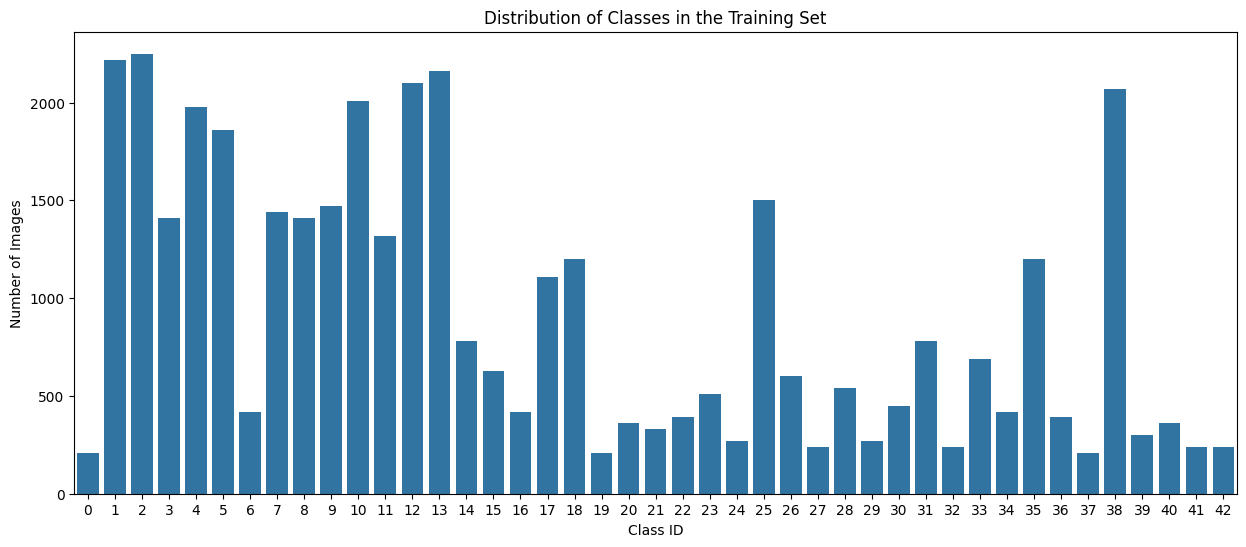

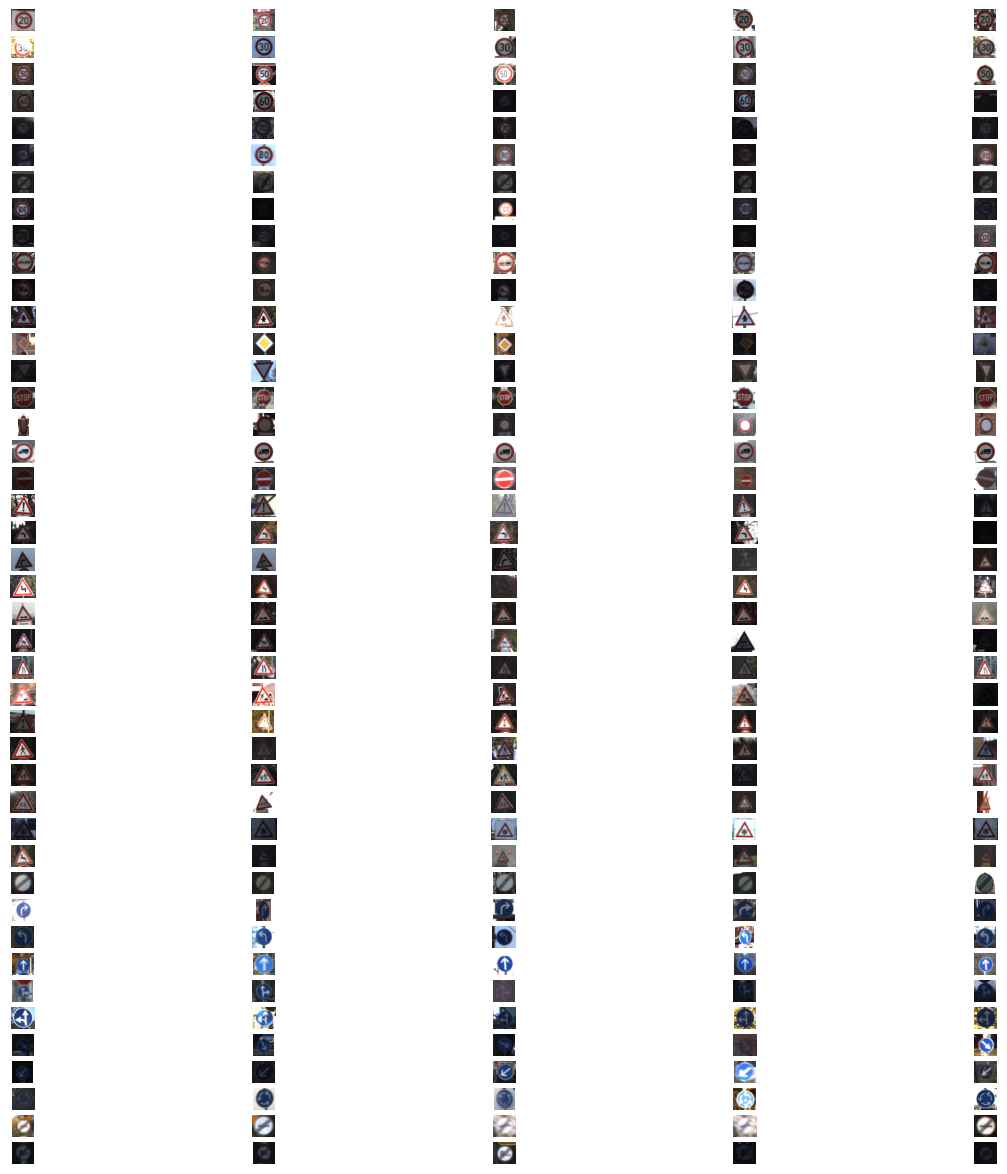

In [5]:
data_dir = './GTSRB'
train_path = os.path.join(data_dir, 'Train')
test_path = os.path.join(data_dir, 'Test')

# Get the number of classes
num_classes = len(os.listdir(train_path))
print(f'Number of classes: {num_classes}')

# Display class distribution
class_counts = []
for i in range(num_classes):
    class_path = os.path.join(train_path, str(i))
    class_counts.append(len(os.listdir(class_path)))

plt.figure(figsize=(15, 6))
sns.barplot(x=list(range(num_classes)), y=class_counts)
plt.title('Distribution of Classes in the Training Set')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.show()

# Display sample images
def display_sample_images(data_path, num_samples=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_classes):
        class_path = os.path.join(data_path, str(i))
        sample_images = os.listdir(class_path)[:num_samples]
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            plt.subplot(num_classes, num_samples, i * num_samples + j + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
    plt.show()

display_sample_images(train_path)

## 4. Data Preprocessing

We will now preprocess the data by resizing images, normalizing pixel values, and one-hot encoding the labels.

In [6]:
IMG_SIZE = 32

def preprocess_data(data_path, num_classes, img_size):
    images = []
    labels = []
    for i in range(num_classes):
        class_path = os.path.join(data_path, str(i))
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(i)
    images = np.array(images) / 255.0
    labels = to_categorical(np.array(labels), num_classes)
    return images, labels

X, y = preprocess_data(train_path, num_classes, IMG_SIZE)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


## 5. Build CNN Model

We will construct a CNN from scratch with multiple convolutional, max-pooling, dropout, and dense layers.

In [7]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model((IMG_SIZE, IMG_SIZE, 3), num_classes)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,523 (2.37 MB)

 Trainable params: 620,523 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Training the Model

Now, we'll train our CNN on the preprocessed training data.

In [8]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3458 - loss: 2.4082 - val_accuracy: 0.9273 - val_loss: 0.3597
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.8404 - loss: 0.5149 - val_accuracy: 0.9674 - val_loss: 0.1435
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.9038 - loss: 0.3079 - val_accuracy: 0.9776 - val_loss: 0.0888
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.9308 - loss: 0.2165 - val_accuracy: 0.9842 - val_loss: 0.0758
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.9453 - loss: 0.1788 - val_accuracy: 0.9907 - val_loss: 0.0448
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 79s 44ms/step - accuracy: 0.9548 - loss: 0.1429 - val_accuracy: 0.9901 - val_loss: 0.0420
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - accuracy: 0.9594 - loss: 0.1285 - val_accuracy: 0.9944 - val_loss: 0.0325
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.9649 - loss: 0.1116 - 

## 7. Evaluation & Confusion Matrix

We'll evaluate the model's performance on the test set and visualize the training history and a confusion matrix.

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9715 - loss: 0.1353
Test Accuracy: 0.9701


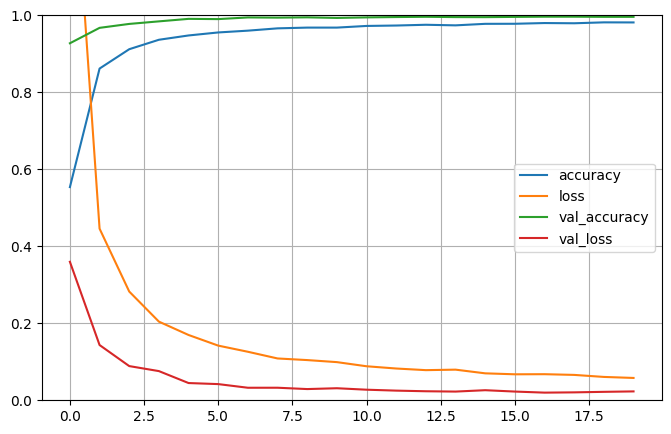

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


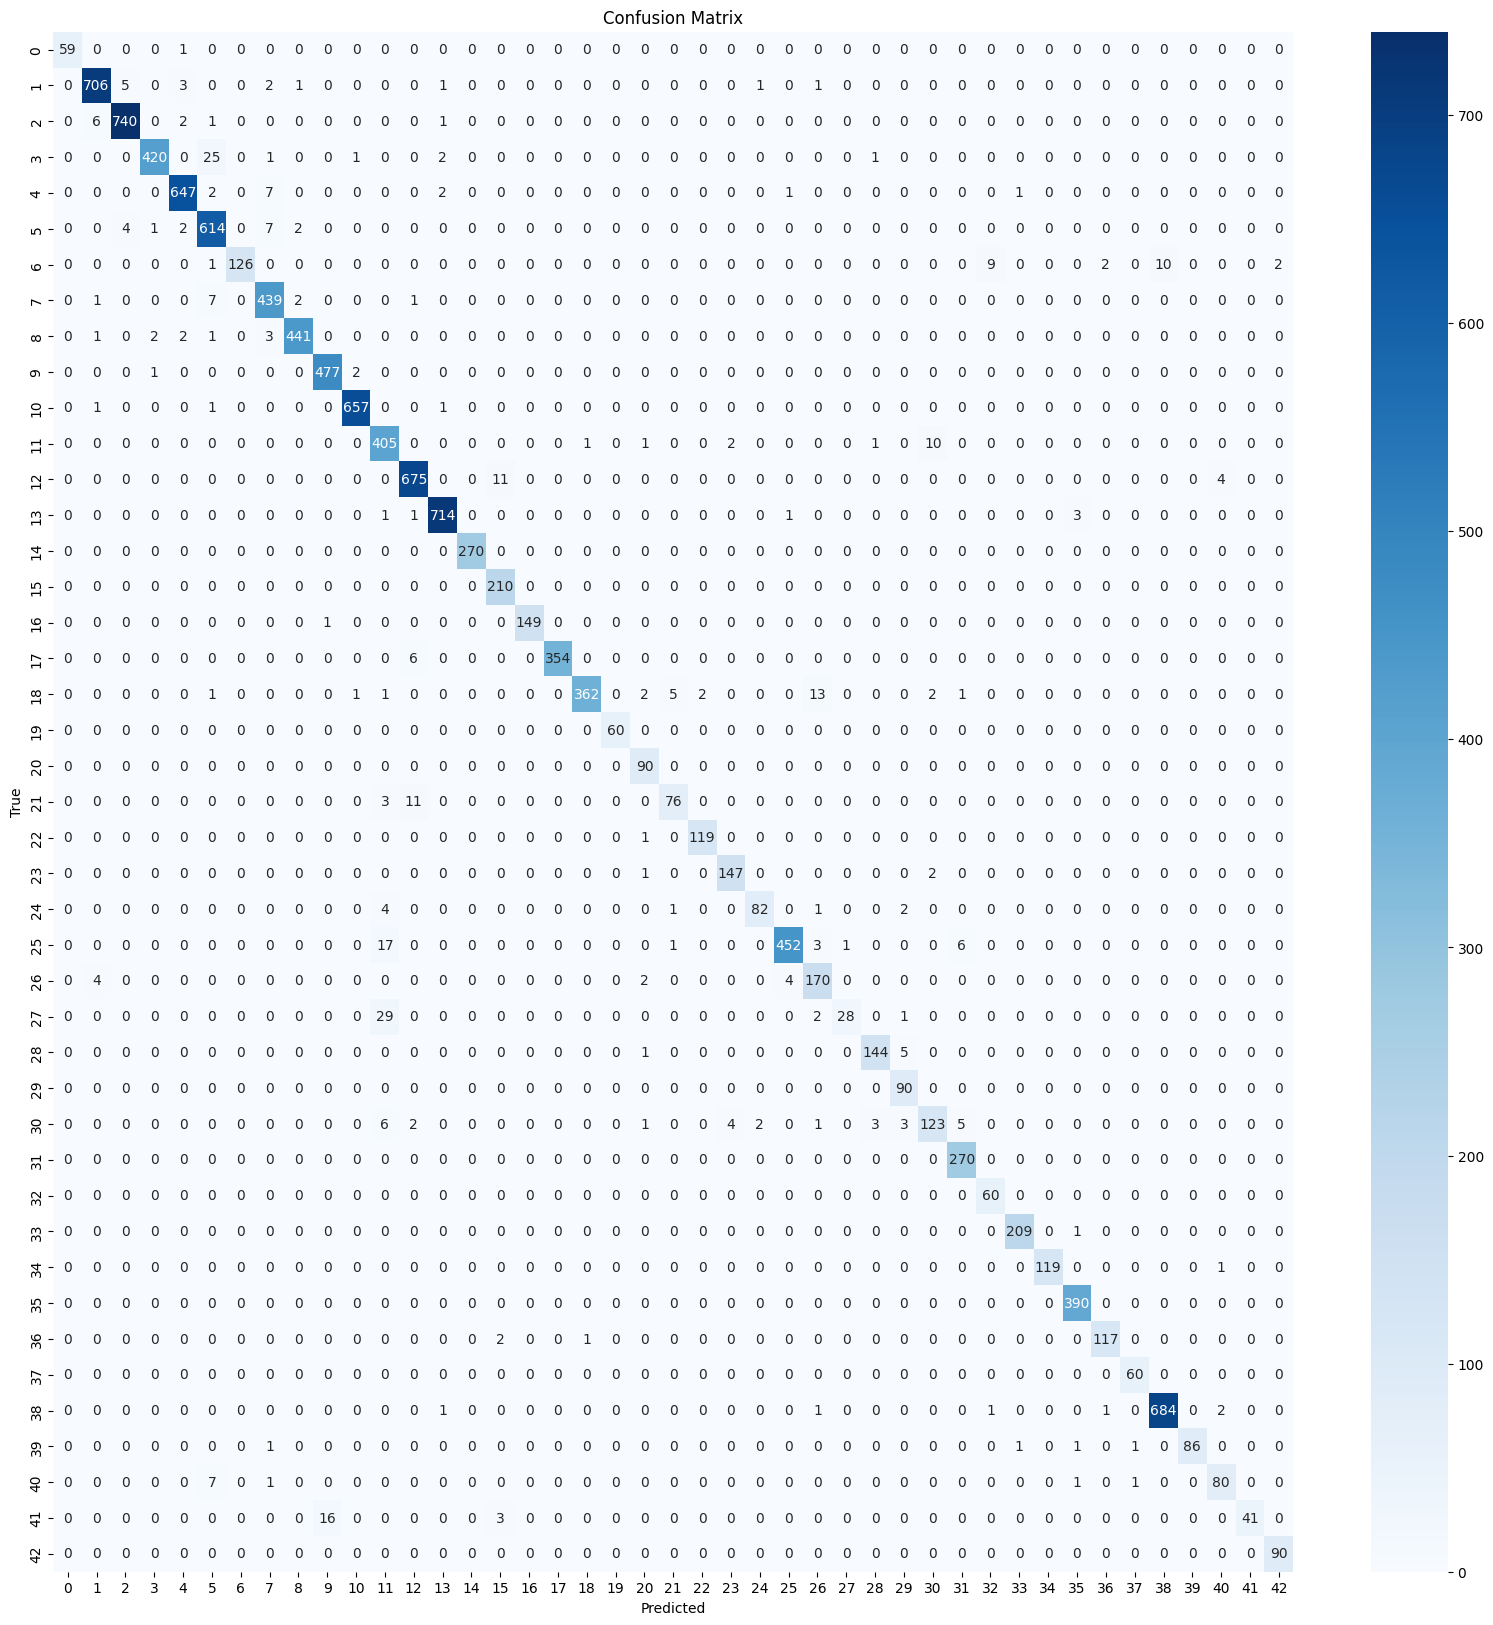

In [9]:
# Load and preprocess test data
test_df = pd.read_csv(os.path.join(data_dir, 'Test.csv'))
X_test = []
y_test_labels = test_df['ClassId'].values

for img_name in test_df['Path']:
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X_test.append(img)

X_test = np.array(X_test) / 255.0
y_test = to_categorical(y_test_labels, num_classes)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 8. Bonus: Data Augmentation & Transfer Learning

### 8.1 Data Augmentation

We use `ImageDataGenerator` to apply real-time data augmentation to our training data to improve model generalization.

In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

model_augmented = build_model((IMG_SIZE, IMG_SIZE, 3), num_classes)
history_augmented = model_augmented.fit(datagen.flow(X_train, y_train, batch_size=32),
                                      epochs=20, validation_data=(X_val, y_val))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 73s 71ms/step - accuracy: 0.2211 - loss: 2.8294 - val_accuracy: 0.6760 - val_loss: 1.0535
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - accuracy: 0.5804 - loss: 1.2991 - val_accuracy: 0.8644 - val_loss: 0.4679
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - accuracy: 0.7084 - loss: 0.8824 - val_accuracy: 0.9172 - val_loss: 0.3037
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.7673 - loss: 0.7105 - val_accuracy: 0.9504 - val_loss: 0.1994
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.8016 - loss: 0.5996 - val_accuracy: 0.9634 - val_loss: 0.1512
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - accuracy: 0.8345 - loss: 0.5159 - val_accuracy: 0.9737 - val_loss: 0.1296
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.8477 - loss: 0.4772 - val_accuracy: 0.9836 - val_loss: 0.0857
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.8570 - loss: 0.4288 - val_accurac

### 8.2 Transfer Learning (VGG16)

Here, we leverage a pre-trained VGG16 model and fine-tune it for our traffic sign recognition task.

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

model_transfer = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_transfer.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_transfer.summary()

history_transfer = model_transfer.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,857,067 (56.68 MB)

 Trainable params: 142,379 (556.17 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 405s 410ms/step - accuracy: 0.2936 - loss: 2.5269 - val_accuracy: 0.5355 - val_loss: 1.4925
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 442s 411ms/step - accuracy: 0.5158 - loss: 1.5650 - val_accuracy: 0.6275 - val_loss: 1.2109
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 404s 412ms/step - accuracy: 0.5829 - loss: 1.3063 - val_accuracy: 0.6702 - val_loss: 1.0498
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 441s 411ms/step - accuracy: 0.6271 - loss: 1.1540 - val_accuracy: 0.7056 - val_loss: 0.9486
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 441s 410ms/step - accuracy: 0.6680 - loss: 1.0361 - val_accuracy: 0.7293 - val_loss: 0.8779
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 402s 410ms/step - accuracy: 0.6884 - loss: 0.9704 - val_accuracy: 0.7482 - val_loss: 0.7987
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 442s 410ms/step - accuracy: 0.7048 - loss: 0.8876 - val_accuracy: 0.7668 - val_loss: 0.7426
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 438s 406ms/step - accuracy: 0.7211 -

### 8.3 Visualize Misclassified Examples

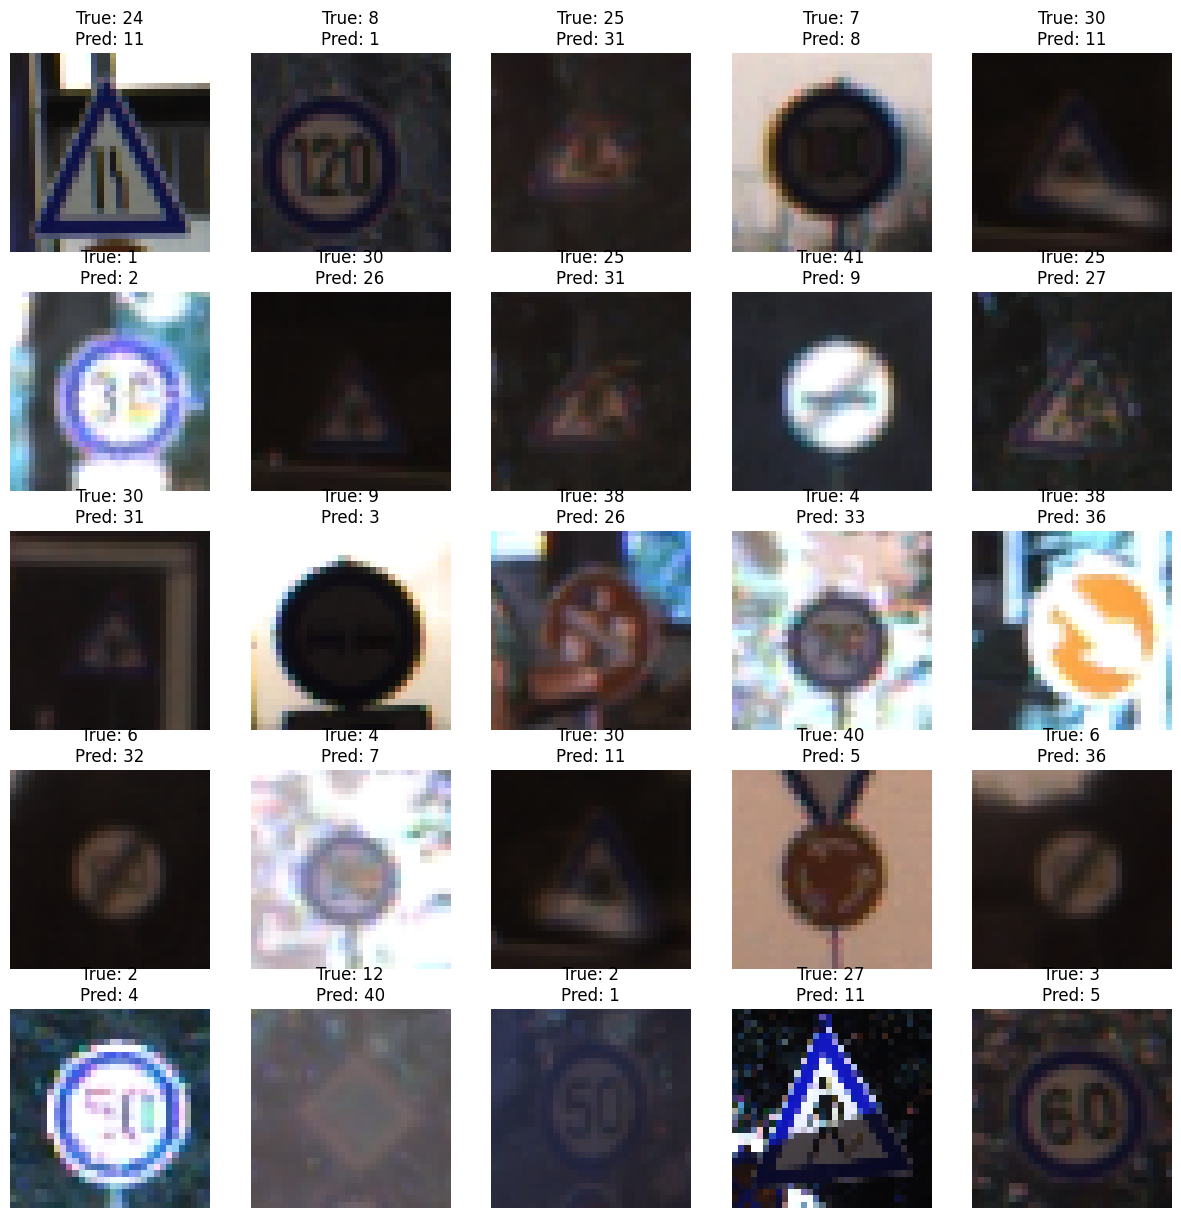

In [12]:
misclassified_indices = np.where(y_pred != y_test_labels)[0]

plt.figure(figsize=(15, 15))
for i, index in enumerate(misclassified_indices[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[index])
    plt.title(f'True: {y_test_labels[index]}\nPred: {y_pred[index]}')
    plt.axis('off')
plt.show()

## 9. Conclusion

In this notebook, we successfully built and trained a CNN for traffic sign recognition. We observed that techniques like data augmentation can help improve the model's robustness. Furthermore, transfer learning with a pre-trained model like VGG16 can provide a strong baseline performance with less training time. The final model achieves a high accuracy on the test set, demonstrating its effectiveness in classifying traffic signs.